In [1]:
%matplotlib inline 

# Classification
***

## Table of Contents
***
* [Aim](#aim)
* [Code Setup](#code-setup)
* [Data Import](#data-import)

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to perform Classification on the Instacart Data

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Constants

In [2]:
instacart_dir = "instacart_2017_05_01/"
my_orders_file = "my_orders.csv"
products_file = "products.csv"
aisles_file = "aisles.csv"
departments_file = "departments.csv"
orders_products_prior_file = "my_order_products__prior.csv"
orders_products_train_file = "my_order_products__train.csv"

### Import Libraries

In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

In [4]:
def read_csv_file(file_name):
    return pd.read_csv(instacart_dir + file_name)

In [5]:
orders = read_csv_file(my_orders_file)
products = read_csv_file(products_file)
aisles = read_csv_file(aisles_file)
orders_products_prior = read_csv_file(orders_products_prior_file)
orders_products_train = read_csv_file(orders_products_train_file)
orders_products = pd.concat([orders_products_prior, orders_products_train])
orders_per_user = []
user_ids = orders.user_id.unique().tolist()
for user_id in user_ids:
    orders_per_user.append(orders.query("user_id == " + str(user_id)))
print("There are ", len(user_ids), "users with a corresponding entry in order history list who's length is also", len(orders_per_user))

There are  20 users with a corresponding entry in order history list who's length is also 20


## Take a specific User

In [6]:
specific_user_order_df = orders_per_user[0]
user_id = specific_user_order_df.user_id.tolist()[0]
print("This user", user_id , "has ", specific_user_order_df.shape[0], " orders")
specific_user_order_df.head()

This user 765 has  6  orders


,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12202,472199,765,prior,1,2,21,NaN
1,12203,1424394,765,prior,2,1,21,20.0
2,12204,889292,765,prior,3,6,21,30.0
3,12205,2809253,765,prior,4,3,20,30.0
4,12206,2392861,765,prior,5,1,12,19.0


### Split into Train and Test Set

In [7]:
max_order_number = specific_user_order_df.order_number.max()
next_user_order = specific_user_order_df.query("order_number == " + str(max_order_number))
train_user_orders = specific_user_order_df.query("order_number < " + str(max_order_number))
next_user_order.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
5,12207,2914876,765,train,6,2,17,8.0


### Join in the Order Products

In [8]:
train_user_orders_prod = train_user_orders.merge(orders_products, on="order_id")[["order_id", "product_id", "add_to_cart_order","order_number", "reordered"]]
train_user_orders_prod.head()

,order_id,product_id,add_to_cart_order,order_number,reordered
0,472199,49463,1,1,0
1,472199,40545,2,1,0
2,1424394,46069,1,2,0
3,1424394,2339,2,2,0
4,1424394,14881,3,2,0


In [9]:
prod_list_of_lists = []
order_number_list = []
order_ids = train_user_orders.order_id.unique().tolist()
print(order_ids)
for order_id in order_ids:
    query = "order_id == " + str(order_id)
    order_number = orders.query(query).order_number.tolist()[0]
    orders_products_order = orders_products.query(query)
    product_list = orders_products_order.product_id.tolist()
    product_list.sort()
    prod_list_of_lists.append(product_list)
    order_number_list.append(order_number)
print(prod_list_of_lists)

[472199, 1424394, 889292, 2809253, 2392861]
[[40545, 49463], [2339, 14881, 14999, 46069, 49463], [23740, 23864, 30842], [7825, 23740, 23864], [7825, 11421, 26779, 27355]]


## Reorder Rate vs Add to Cart

In [10]:
orders_products.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,147221,15511,429,1,0
1,147222,15511,46397,2,0
2,147223,15511,27323,3,0
3,147224,15511,28842,4,1
4,147225,15511,4605,5,0


In [11]:
reorder_rate_to_position = (orders_products
                            .groupby("add_to_cart_order")["reordered"]
                            .sum()
                            .reset_index(name="reordered_count")
                           )
total_reorder_count = reorder_rate_to_position.reordered_count.sum()
print("Total times products reordered :", total_reorder_count)
reorder_rate_to_position.head()

Total times products reordered : 1541


,add_to_cart_order,reordered_count
0,1,204
1,2,195
2,3,172
3,4,153
4,5,136


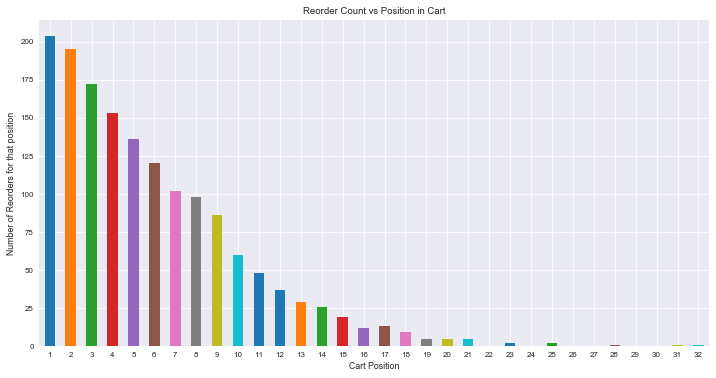

In [12]:
fig, ax = plt.subplots()
reorder_rate_to_position['reordered_count'].plot.bar()
ax.set_xticklabels(reorder_rate_to_position["add_to_cart_order"], rotation='horizontal')
plt.title("Reorder Count vs Position in Cart")
plt.ylabel("Number of Reorders for that position")
plt.xlabel("Cart Position")
plt.show()

This graphs shows that the item that is first in the cart is the most reordered

### Not Reordered to Position

In [13]:
notreordered_orders_products = orders_products.query("reordered == 0")
notreorder_rate_to_position = (notreordered_orders_products
                            .groupby("add_to_cart_order")
                            .size()
                            .reset_index(name="not_reordered_count")
                           )
total_notreorder_count = notreorder_rate_to_position.not_reordered_count.sum()
print("Total times products not reordered :", total_notreorder_count)
notreorder_rate_to_position.head()

Total times products not reordered : 1142


,add_to_cart_order,not_reordered_count
0,1,98
1,2,94
2,3,108
3,4,106
4,5,102


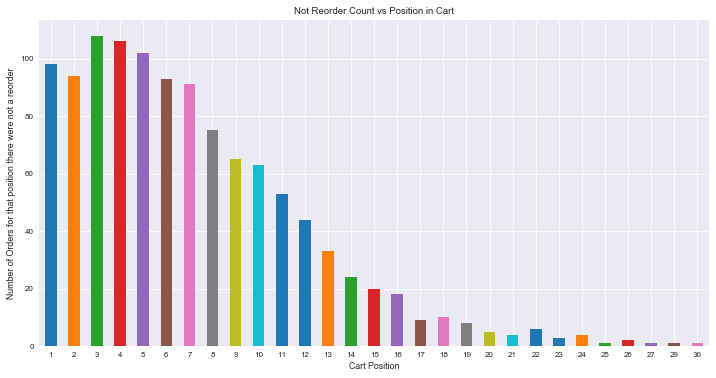

In [14]:
fig, ax = plt.subplots()
notreorder_rate_to_position['not_reordered_count'].plot.bar()
ax.set_xticklabels(notreorder_rate_to_position["add_to_cart_order"], rotation='horizontal')
plt.title("Not Reorder Count vs Position in Cart")
plt.ylabel("Number of Orders for that position there were not a reorder")
plt.xlabel("Cart Position")
plt.show()

In [15]:
order_rates = notreorder_rate_to_position.merge(reorder_rate_to_position, on="add_to_cart_order")
order_rates.head()

,add_to_cart_order,not_reordered_count,reordered_count
0,1,98,204
1,2,94,195
2,3,108,172
3,4,106,153
4,5,102,136


In [16]:
order_rates['reorder_rate'] = order_rates['reordered_count'] /(order_rates['not_reordered_count'] + order_rates['reordered_count'])
order_rates.head()

,add_to_cart_order,not_reordered_count,reordered_count,reorder_rate
0,1,98,204,0.675497
1,2,94,195,0.674740
2,3,108,172,0.614286
3,4,106,153,0.590734
4,5,102,136,0.571429


Text(0,0.5,'Reorder Rate')

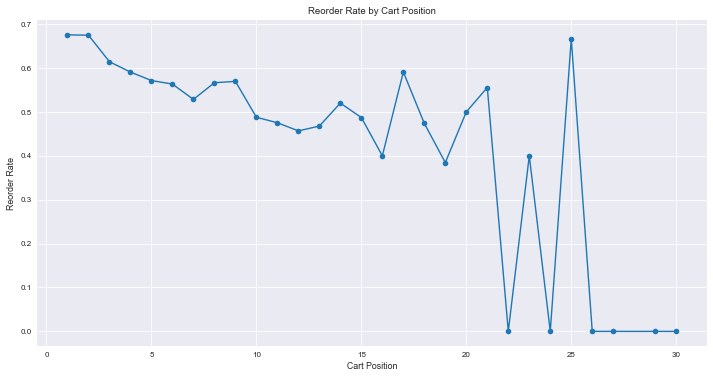

In [17]:
fig = plt.figure()
plt.plot(order_rates["add_to_cart_order"], order_rates['reorder_rate'], "-o")
plt.title("Reorder Rate by Cart Position")
plt.xlabel("Cart Position")
plt.ylabel("Reorder Rate")

### Regression Model with 1st Order Polynomial

As can be seen the graph breaks down after about the 20th position in the cart

In [18]:
x_training_set = order_rates.as_matrix(['add_to_cart_order'])
y_training_set = order_rates.as_matrix(['reorder_rate'])

# Use a line as a quadratic gave negative predictions at cart position of 30 and onwards
# The line gives negative rate after a position of 36 and onwards
poly = PolynomialFeatures(degree=1)
x_training_set_transform = poly.fit_transform(x_training_set)

reorder_rate_reg_model = linear_model.LinearRegression()
reorder_rate_reg_model.fit(x_training_set_transform,y_training_set)

train_score = reorder_rate_reg_model.score(x_training_set_transform, y_training_set)

pos_to_test = 35
position_to_test = poly.fit_transform(pos_to_test)
preditced_reorder_rate_from_position = reorder_rate_reg_model.predict(position_to_test)[0][0]

print("The model score :", train_score, " using the training data and for a cart position of :",pos_to_test, 
      "the model preditced a reorder rate of :", preditced_reorder_rate_from_position)

The model score : 0.570797559844303  using the training data and for a cart position of : 35 the model preditced a reorder rate of : 0.01759267264454467
